In [1]:
%cd ../

/Users/sahel/papers/FederatedLearning


## Deep Learning Experiment

In this section, we tested our method with Tensorflow ”cats vs dogs” Classification Dataset. Each node of the empirical graph $G$ stands for a deep neural network in which the base model is Xception (with 132 layers) and has trained on the ImageNet dataset, also the new model containes a Global Average Pooling 2D, a Dropout, 
and a Dense layer (with linear activation, Adam optimizer, and Binary Cross Entropy loss function) respectively. 
The difference between the nodes is their training datasets.

Suppose that the training dataset for the node i is $img_1, ..., img_t$, we consider the result of the base model for the rth train image ($img_r$) as the feature vector ($x^{(i, r)}$), and the result of the new model as its label ($y^i_r$), and $w^i$ is the weight vector of its Dense layer and the aim of this experiment is to estimate the weight vectors, $\hat{w}^i$ of all the nodes.

The total number of nodes is 100, each node is connected to its 3 nearest neighbours, the ones with the highest weights. We select 20 random nodes as the samplingset for Algorithm 1 (with λ = 0.001 and a fixed number of 1000 iterations). Our method has increased the overall accuracy of the nodes in a significant
shorter time, the needed time for training each model with three learning epochs is almost 20 minutes, so training 100 models lasts 2000 minutes, while the computation time for our algorithm itself is almost than 5 minutes. by adding the time for training the sampling set, which is 20 nodes, the total time would be 405 minutes 
(405 << 2000).

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../algorithm1.png)

In [2]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


### Primal Update 

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [3]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


### Dual Update 

As mentioned in the paper, the dual update has a penalty function(line 10) which is either norm1, norm2, or mocha.

In [4]:
# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Create Deep Learning Graph

In [5]:
# defining the constatnt variables

Image_Width = 150
Image_Height = 150
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3

BATCH_SIZE = 32
EPOCHS = 3

## Neural Network Models

In [6]:
import keras
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

from keras import layers


# get the base(pre-trained) model data
def get_base_model_data():
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )

    base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(Image_Width, Image_Height, Image_Channels),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(Image_Width, Image_Height, Image_Channels))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be normalized
    # from (0, 255) to a range (-1., +1.), the normalization layer
    # does the following, outputs = (inputs - mean) / sqrt(var)
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    return x, inputs


# get the base(pre-trained) model
def get_base_model():
    x, inputs = get_base_model_data()
    outputs = keras.layers.GlobalAveragePooling2D()(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    return model


# get the new(trainable) model
def get_new_model():
    inputs = keras.Input(shape=(2048,))

    x = keras.layers.Dropout(0.2)(inputs)
    outputs = keras.layers.Dense(1)(x)

    extra_model = keras.Model(inputs, outputs)

    extra_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    return extra_model


# get the model
def get_NN_model():
    # base model
    x, inputs = get_base_model_data()

    # new model
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    for layer in model.layers[:-1]:
        layer.trainable = False

    return model


# calculate base model output and true labels for all images
def get_base_model_output():
    '''
    :return base_model_outputs: A list containing the output of the base(pre-trained) model for all the images
    :return true_labels: A list containing the true label of all the images (which is 0 or 1 for each image)
    '''

    # get the base model
    base_model = get_base_model()

    # load the data from tensorflow dataset (all the images)
    (dataset,), metadata = tfds.load(
        "cats_vs_dogs",
        split=["train[:100%]"],
        shuffle_files=True,
        with_info=True,
    )

    # resize the images of the dataset to the standard size
    dataset = dataset.map(lambda item: (tf.image.resize(item['image'], Image_Size), item['label']))
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)

    # get the output of the base model for the dataset
    base_model_outputs = base_model.predict(dataset)

    # obtain the true labels for the dataset
    true_labels = []
    for obj in dataset:
        true_labels += list(np.array(obj[1]))
    true_labels = np.array(true_labels)

    return base_model_outputs, true_labels


## Load Saved(Trained) Data


In [7]:
import json
import os

import numpy as np


# Return the output of the base model and the train vector for the training dataset of this model
def get_model_train_images_data(train_data_image_names, all_images_indices, all_images_size, base_model_outputs, true_labels):
    train_images_vector = np.zeros(all_images_size)
    base_model_output = []
    model_labels = []
    for train_image_name in train_data_image_names:
        index = all_images_indices[train_image_name]
        train_images_vector[index] = 1
        model_labels.append(true_labels[index])
        item_predict = np.concatenate((base_model_outputs[index], [1]))  # [1] is for the bias (b)
        base_model_output.append(item_predict)
    return base_model_output, train_images_vector, model_labels


def get_all_images_dict(data):
    all_images_indices = {}
    cnt = 0
    for train_data in data:
        for i, file_name in enumerate(train_data['train_df']):
            if file_name not in all_images_indices:
                all_images_indices[file_name] = cnt
                cnt += 1
    return all_images_indices


def get_trained_model_weights(raw_model_weights):
    model_weights = []
    for weight in raw_model_weights[-2:]:
        model_weights.append(np.array(weight))
    model_weights = np.array(model_weights)
    return model_weights


# load the trained models data from saved files
def read_trained_data_from_saved_files(train_data_dir):
    '''
    :param train_data_dir: the directory where the trained data is stored
    
    :return data: saved data from the trained models
    '''
    
    data = []
    
    for filename in sorted(os.listdir(train_data_dir)):
        if '.json' not in filename:
            continue
        num = filename.split('_')[-1].replace('.json', '')
        
        # just need the first 100 trained models data
        if int(num) >= 100:
            continue
        
        with open(os.path.join(train_data_dir, filename), 'r') as f:
            data.append(json.load(f))
    
    return data


def load_trained_data(train_data_dir, base_model_output, true_labels):
    '''
    :param train_data_dir: the directory where the trained data is stored
    :param base_model_output: A list containing the output of the base(pre-trained) model for all the images
    :param true_labels: A list containing the true label of all the images (which is 0 or 1 for each image)
    
    :return all_models_train_images: A list containing the images used for training each model
    :return all_models_weights: A list containing the weight of the new model based on training each model
    :return X: A list containing the output of the base model for trainset of each model, which is the features of algorithm 1
    :return Y: A list containing the true labels for trainset of each model, which is the labels of algorithm 1
    '''
    
    # load the trained models data from saved files
    data = read_trained_data_from_saved_files(train_data_dir)
    '''
    data: saved data from the trained models
    '''

    # get the trained dataset and weights of each trained model and also the features of algorithm 1
    all_images_indices = get_all_images_dict(data)
    '''
    all_images_indices: a dictionary from image_name to index
    '''
    all_images_size = len(all_images_indices.keys())
    '''
    all_images_size : total number of images of the (tensorflow) dataset
    '''

    all_models_train_images = []
    all_models_weights = []
    X = []
    '''
    X: A list containing the output of the base model for trainset of each model, which is the features of algorithm 1
    '''
    Y = []
    '''
    Y: A list containing the true labels for trainset of each model, which is the labels of algorithm 1
    '''
    
    for model_data in data:

        base_model_train_images_output, model_train_images, model_labels = get_model_train_images_data(model_data['train_df'], all_images_indices, all_images_size, base_model_output, true_labels)
        '''
        base_model_train_images_output: the output of the base model for the training dataset of this model
        model_train_images: a vector from 0/1 with the size of "all_images_size", model_train_images[i] = 1 if 
                the image with the index i is in the train dataset of this model otherwise model_train_images[i] = 0
        model_labels: the true labels for the training dataset of this model
        '''

        X.append(np.array(base_model_train_images_output))
        Y.append(np.array(model_labels))

        all_models_train_images.append(model_train_images)

        model_weights = get_trained_model_weights(model_data['weights'])
        '''
        model_weights: the weights of this model for the new model (trainable layers)
        '''
        all_models_weights.append(model_weights)

    X = np.array(X)
    Y = np.array(Y)


    return all_models_train_images, all_models_weights, X, Y


## Create graph


In [8]:
# calculate the distance between the given nodes of the graph
def get_dist(first_node, second_node):
    all_equals = np.where(first_node == second_node)[0]
    equal_train_images = np.where(first_node[all_equals] == 1)[0]
    dist = len(equal_train_images) / len(np.where(first_node == 1)[0])
    return dist


# calculate the adjacency matrix and the weight vector of the empirical graph G
def get_B_and_weight_vec(all_models_train_images, neigh_cnt=3):
    '''
    :param trained_models_train_images: A list containing the images used for training each model
    :param neigh_cnt: number of the neighbors for each node of the empirical graph G
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    '''
    
    N = len(all_models_train_images)
    E = int(N * (N - 1) / 2)

    weight_vec = np.zeros(E)
    '''
    the weight vector of the edges of the empirical graph G
    '''
    B = np.zeros((E, N))
    '''
    the adjacency matrix of the empirical graph G
    '''
    
    cnt = 0
    '''
    number of edges of the empirical graph G
    '''
    for i in range(N):
        node_dists = []
        '''
        a list containing the distance between node i and other nodes of the graph
        '''
        for j in range(N):
            if j == i:
                continue
            node_dists.append(get_dist(all_models_train_images[i], all_models_train_images[j]))
        
        # sort node_dists in order to pick the nearest nodes to the node i 
        node_dists.sort(reverse=True)

        node_cnt = 0
        for j in range(N):
            
            if node_cnt >= neigh_cnt:
                break
                
            if j == i:
                continue
                
            # calculate the distance between node i and j of the graph
            dist = get_dist(all_models_train_images[i], all_models_train_images[j])
            if dist == 0 or dist < node_dists[neigh_cnt]:
                continue

            node_cnt += 1
            B[cnt][i] = 1
            B[cnt][j] = -1
            weight_vec[cnt] = dist
            cnt += 1

    B = B[:cnt, :]
    weight_vec = weight_vec[:cnt]
    return B, weight_vec



## Save figures


In [9]:
import numpy as np
import matplotlib.pyplot as plt


# calculate new model output for all images
def get_new_model_output(new_model_weights, base_model_output):
    new_model_weights = [np.array(new_model_weights[:-1]).reshape(-1, 1), np.array(new_model_weights[-1:])]

    new_model = get_new_model()
    new_model.set_weights(new_model_weights)

    model_predicts = new_model.predict(base_model_output).flatten()
    model_predicts[model_predicts > 0] = 1
    model_predicts[model_predicts <= 0] = 0

    return model_predicts


def save_figures(alg1_estimated_weights, original_weights, lambda_lasso, base_model_output, true_labels):
    '''

    :param alg1_estimated_weights: A list containing the weights of the models estimated by algorithm 1
    :param original_weights: A list containing the weights of the models based on training each model
    :param lambda_lasso: lambda_lasso parameter used for algorithm 1
    :param base_model_output: A list containing the output of the base model(pre-trained model) for all the images
    :param true_labels: A list containing the true label of all the images

    '''

    N = len(alg1_estimated_weights)

    alq1_scores = []  # blue curve
    trained_model_scores = []  # orange curve

    for i in range(N):

        # the trained model output for all images
        trained_model_output = get_new_model_output(original_weights[i], base_model_output)
        # orange curve
        trained_model_score = np.where(true_labels == trained_model_output)[0].shape[0] / len(true_labels)
        trained_model_scores.append(trained_model_score)

        # alg1 output for all images
        alg1_output = get_new_model_output(alg1_estimated_weights[i], base_model_output)
        # blue curve
        alg1_score = np.where(true_labels == alg1_output)[0].shape[0] / len(alg1_output)
        alq1_scores.append(alg1_score)

    x_axis = [i for i in range(N)]
    plt.close()
    plt.plot(x_axis, alq1_scores, label='algorithm1')
    plt.plot(x_axis, trained_model_scores, label='deep learning')
    plt.title('alg1 vs trained accuracy')
    plt.xlabel('model')
    plt.ylabel('accuracy')
    plt.legend(loc="lower left")
    plt.savefig('results/deeplearning_accuracy.png')


## Main


In [10]:
import random
import datetime
from algorithm.algorithm_utils import prepare_data_for_algorithm1


def get_Y_and_W(X, trained_models_weights):
    '''
    :param X: A list of the features of algorithm 1
    :param trained_models_weights: A list containing the weight of the new model based on training each model
    '''

    Y = []
    W = []
    for i in range(len(X)):

        # The weights of the trainable layers (the new model) of the i_th trained model
        weights = trained_models_weights[i]

        # the weights of the dense layer of the model
        w1 = np.array(weights[-2]).flatten()

        # the bias of the dense layer
        w2 = weights[-1]

        # combining the weights and the bias of the dense layer of the model, which is the weight of the node for alg1
        w = np.concatenate((w1, w2))
        W.append(w)

        # the label of the i_th node for alg1
        Y.append(X[i].dot(w))

    Y = np.array(Y)
    W = np.array(W)

    return Y, W


def deep_learning_run(lambda_lasso=0.001, K=1000, penalty_func='norm1', train_data_dir='data/deep_learning_data'):

    # calculate base model output and true labels for all images
    base_model_output, true_labels = get_base_model_output()
    '''
    base_model_output: A list containing the output of the base(pre-trained) model for all the images
    true_labels: A list containing the true label of all the images (which is 0 or 1 for each image)
    '''

    # load trained data from saved models in train_data_dir
    trained_models_train_images, trained_models_weights, X, Y = load_trained_data(train_data_dir, base_model_output, true_labels)
    '''
    trained_models_train_images: A list containing the images used for training each model
    trained_models_weights : A list containing the weight of the new model based on training each model
    X : A list containing the output of the base model for trainset of each model, which is the features of algorithm 1
    Y : A list containing the true labels for trainset of each model, which is the labels of algorithm 1
    '''

    # create B and weight_vec for the empirical graph G
    B, weight_vec = get_B_and_weight_vec(trained_models_train_images)
    E, N = B.shape
    '''
    B : Incidence matrix of the empirical graph G
    weight_vec : Wight of each edge of the empirical graph G
    '''

    # calculate the weights(W) of the empirical graph G
    Y, W = get_Y_and_W(X, trained_models_weights)
    '''
    W : The weights of the nodes for the algorihtm 1
    '''

    # choose sampling set for alg1
    M=0.2
#     samplingset = random.sample([i for i in range(N)], k=int(M * N))
    samplingset = [53, 92, 99, 19, 16, 32, 6, 9, 39, 43, 34, 54, 23, 8, 13, 88, 1, 62, 22, 60]
    '''
    samplingset : The samplingset selected for algorithm 1
    '''

    # alg1
    start_time = datetime.datetime.now()
    print ('start algorithm 1 in', start_time)
    data = prepare_data_for_algorithm1(B, X, Y, loss_func='linear_reg')
    _, alg1_estimated_weights = algorithm_1(K, B, weight_vec, data, Y, samplingset, lambda_lasso, penalty_func)
    '''
    alg1_estimated_weights : The estimated weights by algorithm 1
    '''
    end_time = datetime.datetime.now()
    print ('finish algorithm 1 in', end_time)
    print('algorithm1 computational time', end_time-start_time)

    # save the orange and blue fig
    save_figures(alg1_estimated_weights, W, lambda_lasso, base_model_output, true_labels)

    return alg1_estimated_weights


/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/ipykernel_launcher.py:125: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/ipykernel_launcher.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do thi

start algorithm 1 in 2021-05-22 00:30:24.648966
finish algorithm 1 in 2021-05-22 00:35:29.979978
algorithm1 computational time 0:05:05.331012


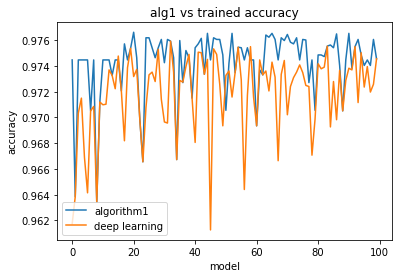

In [11]:
res = deep_learning_run(0.001)

This Figure shows the accuracy for each model obtained after 1000 number of iterations 
used in Algorithm 1 based on the squared error loss . 
In this figure, the blue line shows the accuracy of the models 
based on the weights estimated by our method and the orange line shows 
the accuracy of the models by training its weights by the deep neural 
network after three epochs.

## Train models and save them

In [ ]:
import json
import tensorflow_datasets as tfds


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


# convert pandas.dataset to pandas.dataframe
def convert_dataset_to_dataframe(dataset):
    file_names = []
    labels = []
    for obj in dataset:
        file_names.append(obj['image/filename'].numpy().decode('utf-8'))
        labels.append(obj['label'].numpy())
    df = pd.DataFrame(data={'filename': file_names, 'label': labels})
    return df


# prepare train/validation/test datasets for training the model
def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    # ds_size = len(list(ds))
    ds_size = 23262

    train_size = int(ds_size * train_ratio)
    validate_size = int(ds_size * val_ratio)
    test_size = int(ds_size * test_ratio)

    # split the dataset to train/validation/test datasets based on their ratios
    train_ds = dataset.take(train_size)
    validation_ds = dataset.skip(train_size).take(validate_size)
    test_ds = dataset.skip(train_size + validate_size).take(test_size)

    # convert train/validation/test pandas.dataset to pandas.dataframe in order to save them
    train_df = convert_dataset_to_dataframe(train_ds)
    validate_df = convert_dataset_to_dataframe(validation_ds)
    test_df = convert_dataset_to_dataframe(test_ds)

    # resize the images of train/validation/test dataset to the standard size
    train_ds = train_ds.map(lambda item: (tf.image.resize(item['image'], Image_Size), item['label']))
    validation_ds = validation_ds.map(lambda item: (tf.image.resize(item['image'], Image_Size), item['label']))
    test_ds = test_ds.map(lambda item: (tf.image.resize(item['image'], Image_Size), item['label']))

    # prepare train/validation/test dataset for training the model
    train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)
    validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)
    test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)

    return (train_ds, train_df), (validation_ds, validate_df), (test_ds, test_df)


n_models = 200

# train different models with different train/validation/test datasets and save its data
for i in range(n_models):

    # load the data from tensorflow dataset
    dataset, metadata = tfds.load(
        "cats_vs_dogs",
        shuffle_files=True,
        with_info=True,
    )
    dataset = dataset['train']

    # prepare train/validation/test datasets for training the model
    (train_ds, train_df), (validation_ds, validate_df), (test_ds, test_df) = split_dataset(dataset, train_ratio=0.75, val_ratio=0.15, test_ratio=0.1)
    '''
    train_ds: dataset of the training data for the model (we need dataset to train the model)
    train_df: dataframe of the training data for the model (we need dataframe to save the model's data) 

    validation_ds: dataset of the validation data for the model
    validate_df: dataframe of the validation data for the model

    test_ds: dataset of the test data for the model
    test_df: dataframe of the test data for the model
    '''
    # create the model
    model = get_NN_model()

    # train the model for the selected train and validation datasets
    start = datetime.datetime.now()
    model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)
    print(datetime.datetime.now() - start)

    # calculate the predicted labels of the trained model for the test dataset
    pred_labels = model.predict(test_ds).flatten()
    pred_labels[pred_labels <= 0] = 0
    pred_labels[pred_labels > 0] = 1

    # obtain the true labels for the test dataset
    true_labels = []
    for obj in test_ds:
        true_labels += list(np.array(obj[1]))
    true_labels = np.array(true_labels)

    # calculate the accuracy of the model for the test dataset
    accuracy = np.where(true_labels == pred_labels)[0].shape[0] / test_df.shape[0]
    print ('\n\n\nthe accuracy is: ', accuracy)

    # the weights of the trainable layers of the model
    weights = model.get_weights()[-2:]

    # useful model's data to save
    model_data = {
        'score': accuracy,
        'train_df': train_df['filename'].values,
        'validate_df': validate_df['filename'].values,
        'test_df': test_df['filename'].values,
        'weights': weights,
    }

    # save trained data
    with open('deep_learning_lasso/deep_learning_data/new_deeplearning_%d.json' % i, 'w') as f:
        f.write(json.dumps(model_data, cls=NpEncoder))

